üî∑ Paso 1: Cargar el Dataset y An√°lisis Exploratorio (EDA)

In [1]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("bank-full.csv", sep=';')

# Mostrar las primeras filas
df.head()


age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

# New section

üìä Descripci√≥n general

In [3]:
print(f"Forma del dataset: {df.shape}\n")
print("Resumen de columnas y tipos de datos:")

df_summary = pd.DataFrame({
    'Columna': df.columns,
    'Tipo de dato': df.dtypes.values,
    'Valores √∫nicos': [df[col].nunique() for col in df.columns],
    'Valores nulos': df.isnull().sum().values
})

print(df_summary.to_string(index=False))


Forma del dataset: (45211, 17)

Resumen de columnas y tipos de datos:
  Columna Tipo de dato  Valores √∫nicos  Valores nulos
      age        int64              77              0
      job       object              12              0
  marital       object               3              0
education       object               4              0
  default       object               2              0
  balance        int64            7168              0
  housing       object               2              0
     loan       object               2              0
  contact       object               3              0
      day        int64              31              0
    month       object              12              0
 duration        int64            1573              0
 campaign        int64              48              0
    pdays        int64             559              0
 previous        int64              41              0
 poutcome       object               4              0
        y  

üìà Estad√≠sticas descriptivas

In [4]:
# Estad√≠sticas de variables num√©ricas
df.describe()

# Estad√≠sticas de variables categ√≥ricas
df.describe(include='object')


job  marital  education default housing   loan   contact  \
count         45211    45211      45211   45211   45211  45211     45211   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
freq           9732    27214      23202   44396   25130  37967     29285   

        month poutcome      y  
count   45211    45211  45211  
unique     12        4      2  
top       may  unknown     no  
freq    13766    36959  39922

üîç Distribuci√≥n de la variable objetivo y

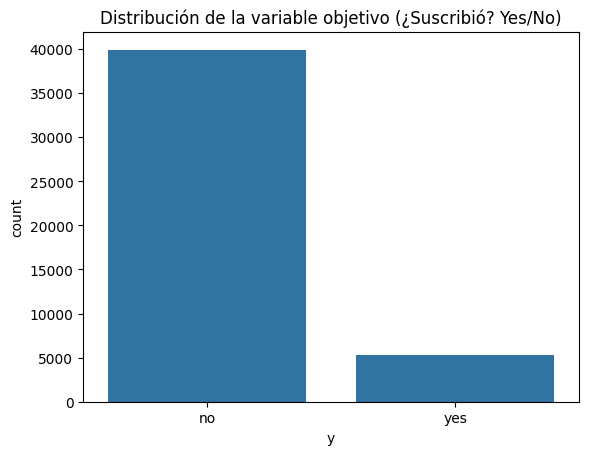

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='y')
plt.title('Distribuci√≥n de la variable objetivo (¬øSuscribi√≥? Yes/No)')
plt.show()


üìâ Correlaci√≥n entre variables num√©ricas

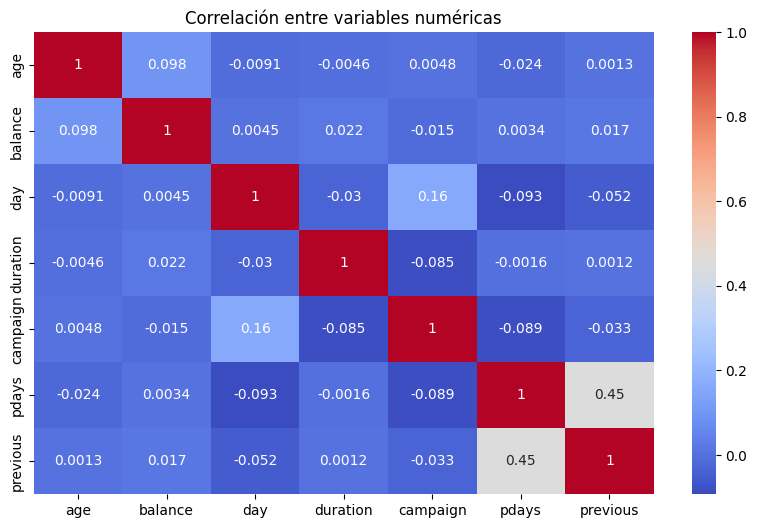

In [6]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlaci√≥n entre variables num√©ricas")
plt.show()


üî∑ Paso 2: Preprocesamiento y Transformaci√≥n de los Datos
Este paso incluye:

Tratamiento de valores nulos o codificados como unknown

Codificaci√≥n de variables categ√≥ricas

Transformaci√≥n de variables tipo fecha (si las hubiera)

Separaci√≥n de variables predictoras y target

‚úÖ 2.1 Tratamiento de valores nulos
Este dataset no tiene NaN, pero usa unknown para representar datos faltantes.

In [7]:
# Contar valores 'unknown' por columna
unknowns = df.apply(lambda x: (x == 'unknown').sum())
unknowns[unknowns > 0]


job            288
education     1857
contact      13020
poutcome     36959
dtype: int64

no eliminar filas, sino agrupar unknown en una categor√≠a expl√≠cita ("Desconocido").

üè∑Ô∏è 2.2 Codificaci√≥n de variables categ√≥ricas
Primero, identificamos las variables categ√≥ricas:

In [8]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('y')  # quitamos la variable objetivo
cat_cols


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

Usaremos One-Hot Encoding para estas variables. Tambi√©n codificamos el objetivo (y) como 0 y 1.

In [9]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Codificar la variable objetivo
df_encoded['y'] = df['y'].map({'no': 0, 'yes': 1})


üïí 2.3 Transformaci√≥n de fechas
Este dataset no tiene fechas expl√≠citas, pero month y day pueden tratarse como num√©ricas.

In [10]:
import calendar

# Mapear mes a n√∫mero (ej: jan -> 1, feb -> 2, ...)
month_map = {month.lower(): index for index, month in enumerate(calendar.month_abbr) if month}

# Aplicar mapeo directamente sobre el DataFrame original
df['month_num'] = df['month'].str.lower().map(month_map)

# Luego puedes eliminar 'month' y seguir
df.drop(columns=['month'], inplace=True)

# Continuar con get_dummies()
df_encoded = pd.get_dummies(df, columns=[col for col in df.columns if df[col].dtype == 'object' and col != 'y'], drop_first=True)

# Codificar 'y'
df_encoded['y'] = df['y'].map({'no': 0, 'yes': 1})


In [11]:
# Ya es num√©rico, no hace falta convertir
df_encoded['day'] = df['day']


üîÑ 2.4 Separar X e y para modelado

In [12]:
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']


üî∑ Paso 3: Entrenamiento de Modelos de Clasificaci√≥n
Vamos a entrenar tres modelos diferentes:

Regresi√≥n Log√≠stica

Random Forest

XGBoost

‚úÖ 3.1 Separaci√≥n de entrenamiento y prueba

In [13]:
from sklearn.model_selection import train_test_split

# Variables predictoras y target
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

# 80% entrenamiento, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


üìä 3.2 Funci√≥n para evaluar modelos

In [14]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print(f"\nüîπ Resultados para: {nombre}")
    print("Entrenamiento:")
    print(f"  Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"  F1 Score: {f1_score(y_train, y_pred_train):.4f}")

    print("\nTest:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"  F1 Score: {f1_score(y_test, y_pred_test):.4f}")

    print("\nReporte de Clasificaci√≥n:")
    print(classification_report(y_test, y_pred_test))
    print("Matriz de Confusi√≥n:")
    print(confusion_matrix(y_test, y_pred_test))


1Ô∏è‚É£ Regresi√≥n Log√≠stica

In [15]:
from sklearn.linear_model import LogisticRegression

modelo_lr = LogisticRegression(max_iter=1000)
evaluar_modelo("Regresi√≥n Log√≠stica", modelo_lr, X_train, X_test, y_train, y_test)



üîπ Resultados para: Regresi√≥n Log√≠stica
Entrenamiento:
  Accuracy: 0.8992
  F1 Score: 0.4076

Test:
  Accuracy: 0.8955
  F1 Score: 0.4119

Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7952
           1       0.64      0.30      0.41      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043

Matriz de Confusi√≥n:
[[7767  185]
 [ 760  331]]


c:\Users\nichi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2Ô∏è‚É£ Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluar_modelo("Random Forest", modelo_rf, X_train, X_test, y_train, y_test)



üîπ Resultados para: Random Forest
Entrenamiento:
  Accuracy: 1.0000
  F1 Score: 1.0000

Test:
  Accuracy: 0.9012
  F1 Score: 0.4811

Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7952
           1       0.66      0.38      0.48      1091

    accuracy                           0.90      9043
   macro avg       0.79      0.68      0.71      9043
weighted avg       0.89      0.90      0.89      9043

Matriz de Confusi√≥n:
[[7736  216]
 [ 677  414]]


3Ô∏è‚É£ XGBoost

Primero instala si no lo tienes:

In [17]:
pip install xgboost


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 6.3/150.0 MB 38.1 MB/s eta 0:00:04
   --- ------------------------------------ 11.8/150.0 MB 32.2 MB/s eta 0:00:05
   ---- ----------------------------------- 17.8/150.0 MB 31.0 MB/s eta 0:00:05
   ------ --------------------------------- 24.1/150.0 MB 30.9 MB/s eta 0:00:05
   -------- ------------------------------- 30.4/150.0 MB 31.0 MB/s eta 0:00:04
   --------- ------------------------------ 37.0/150.0 MB 30.9 MB/s eta 0:00:04
   ----------- ---------------------------- 43.8/150.0 MB 31.3 MB/s eta 0:00:04
   ------------- -------------------------- 49.3/150.0 MB 31.1 MB/s eta 0:00:04
   -------------- ------------------------- 55.1/150.0 MB 30.5 MB/s eta 0:00:04
   ---------------- ----------------------- 62.4/150.0 MB 31.1 MB/s eta 0:00:03
   ------------------ --------------------- 70.0/150.0 MB 31.7 MB/s eta 0:00:03
   -------------------- ------------------- 77.9/1

Y luego:

In [18]:
from xgboost import XGBClassifier

modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluar_modelo("XGBoost", modelo_xgb, X_train, X_test, y_train, y_test)



üîπ Resultados para: XGBoost
Entrenamiento:
  Accuracy: 0.9553
  F1 Score: 0.7884

Test:
  Accuracy: 0.9041
  F1 Score: 0.5482

Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7952
           1       0.64      0.48      0.55      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.72      0.75      9043
weighted avg       0.90      0.90      0.90      9043

Matriz de Confusi√≥n:
[[7650  302]
 [ 565  526]]


c:\Users\nichi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


üî∑ Paso 4: Comparaci√≥n y Selecci√≥n del Mejor Modelo
Despu√©s de haber ejecutado los tres modelos y evaluado sus m√©tricas (accuracy y F1 Score), vamos a crear una tabla comparativa.

‚úÖ 4.1 Recopilar resultados
Ejecuta cada modelo como te mostr√©, y luego guarda los resultados:

In [19]:
# Calculamos predicciones para los tres modelos
y_pred_lr = modelo_lr.predict(X_test)
y_pred_rf = modelo_rf.predict(X_test)
y_pred_xgb = modelo_xgb.predict(X_test)

# Creamos una tabla de m√©tricas
resultados = {
    'Modelo': ['Regresi√≥n Log√≠stica', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ]
}

import pandas as pd
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)


Modelo  Accuracy  F1 Score
0              XGBoost  0.904125  0.548202
1        Random Forest  0.901250  0.481116
2  Regresi√≥n Log√≠stica  0.895499  0.411948

üèÜ 4.2 Selecci√≥n del mejor modelo

In [20]:
# Elegimos el mejor modelo seg√∫n F1
mejor_modelo = modelo_xgb  # cambia seg√∫n tus resultados


F1 Score es m√°s importante aqu√≠ que Accuracy, ya que la clase positiva (suscribi√≥ = yes) suele estar desbalanceada y F1 equilibra precisi√≥n y recall.

üî∑ Importancia de Variables
‚úÖ Para modelos como XGBoost o Random Forest, podemos usar el atributo .feature_importances_.

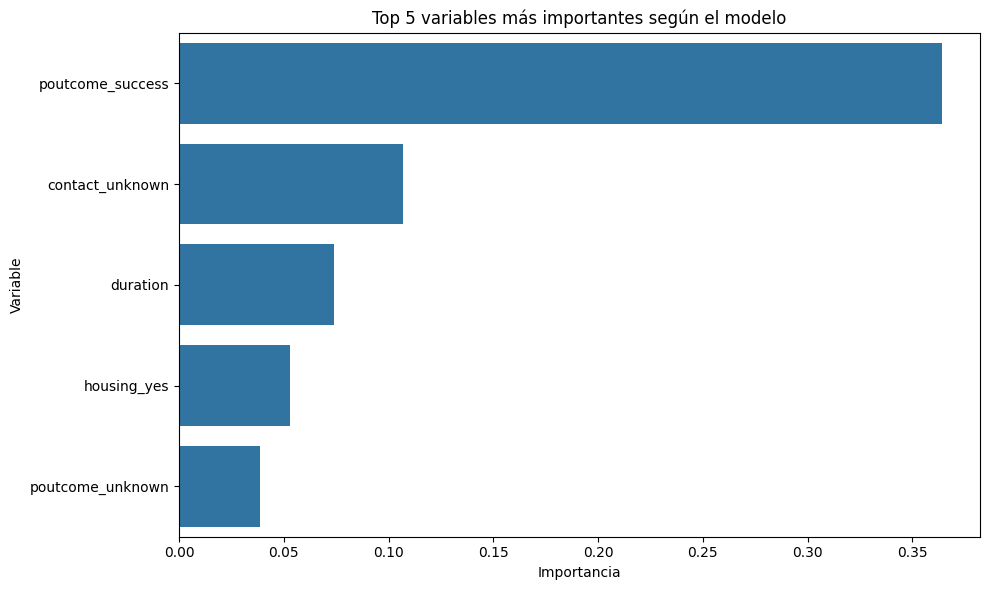

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extraemos la importancia de variables
importancia = pd.Series(mejor_modelo.feature_importances_, index=X.columns)

# Mostramos las 15 m√°s importantes
importancia = importancia.sort_values(ascending=False).head(5)

# Gr√°fico
plt.figure(figsize=(10, 6))
sns.barplot(x=importancia, y=importancia.index)
plt.title("Top 5 variables m√°s importantes seg√∫n el modelo")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


Este gr√°fico te permitir√° incluir en tu presentaci√≥n:

Qu√© atributos afectan m√°s la probabilidad de que un cliente se suscriba (y = yes)

C√≥mo interpretar posibles decisiones de negocio o reglas

üî∑ Paso 5: Entrenamiento Final y Discusi√≥n de Resultados
Ahora que ya sabemos cu√°l es el mejor modelo, lo entrenaremos con el conjunto completo de datos, es decir, sin dividir en train/test. Esto permite aprovechar todos los registros disponibles para hacer predicciones reales o para implementarlo.

In [22]:
# Entrenar el modelo seleccionado con todos los datos
mejor_modelo.fit(X, y)


c:\Users\nichi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

‚úÖ 5.3 Discusi√≥n de resultados
En tu presentaci√≥n o memoria puedes incluir:

Modelo final: XGBoost (u otro seg√∫n F1)

Motivo de selecci√≥n: mejor equilibrio entre precisi√≥n y recall

Variables m√°s importantes: vistas en el gr√°fico anterior

Acciones sugeridas:

Enfocarse en campa√±as con clientes con ciertas caracter√≠sticas (duration, contact, etc.)

Profundizar en las variables que m√°s influyen en decisiones de suscripci√≥n